<a href="https://colab.research.google.com/github/skumarudel/DSPS_SKumar/blob/master/FinalExam/DSPS2021_FinalExam_SajanKumar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

@ Final exam from Sajan Kumar

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
cd "/content/drive/MyDrive/DSPSFinalExam"

/content/drive/MyDrive/DSPSFinalExam


In [113]:
#hide
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from collections import OrderedDict
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from functools import reduce
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
%matplotlib inline

# Task I - Data Acquisition code
- Download data from kaggle using api (see the commented code below)
- Save the data in directory DSPSFinalExam on my drive
- However training metadata was different on kaggle as compared to one shown in the exam. So I decided to download the metadata from another source https://zenodo.org/record/2539456#.YbZ0hrtOlH5

In [4]:
#!mkdir .kaggle
#!mv kaggle.json .kaggle/
#!chmod 600 .kaggle/kaggle.json
#!ls .kaggle


#import json
#envs = json.load(open(".kaggle/kaggle.json", "r"))
#import os
#os.environ["KAGGLE_USERNAME"] = envs["username"]
#os.environ["KAGGLE_KEY"] = envs["key"]

#!pip install kaggle

#!kaggle competitions download PLAsTiCC-2018 -f training_set.csv
#!kaggle competitions download PLAsTiCC-2018 -f training_set_metadata.csv



In [5]:
# load the data
lcvs = pd.read_csv("training_set.csv.zip", compression='zip')

In [6]:
print("The dataset contains: (observations, columns)", lcvs.shape)

The dataset contains: (observations, columns) (1421705, 6)


In [7]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [8]:
lcvs.dtypes

object_id      int64
mjd          float64
passband       int64
flux         float64
flux_err     float64
detected       int64
dtype: object

In [9]:
lcvs.isnull().values.any()

False

There are no missing values in the dataframe

For each object there are 6 time series in 6 different passbands (see overview.) 

In [10]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [11]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".format(objects.shape[0]))

There are 7848 astrophysical simulated objects in my dataset


In [12]:
#metadata = pd.read_csv("training_set_metadata.csv")   # this is downloaded from kaggle
# it has the shape of (7848,12)
# However, the shape in the exam was (7848,26)
# Therefore I decided to download the data from another source https://zenodo.org/record/2539456#.YbZ0hrtOlH5 
#metadata.head()
#metadata.shape
#metadata.columns


Fron now on, I will be using the below metadata downloeded from different source to match what is given in the exam
https://zenodo.org/record/2539456#.YbZ0hrtOlH5

In [13]:
metadata = pd.read_csv("/content/drive/MyDrive/DSPSFinalExam/plasticc_train_metadata.csv.gz") # this one is downloaded from https://zenodo.org/record/2539456#.YbZ0hrtOlH5
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,92,1,0.000,0.000,0.000,0.0,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,88,1,1.817,45.703,0.000,0.0,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,42,2,0.233,40.328,0.004,4.5,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,90,1,0.301,40.969,-0.004,257.7,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,90,1,0.193,39.866,-0.002,-368.8,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
metadata.shape

(7848, 26)

In [15]:
metadata.columns

Index(['object_id', 'ra', 'decl', 'ddf_bool', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target',
       'true_target', 'true_submodel', 'true_z', 'true_distmod',
       'true_lensdmu', 'true_vpec', 'true_rv', 'true_av', 'true_peakmjd',
       'libid_cadence', 'tflux_u', 'tflux_g', 'tflux_r', 'tflux_i', 'tflux_z',
       'tflux_y'],
      dtype='object')

In [16]:
print("The metadata dataset contains more information for each time series: (time-series, columns)", metadata.shape)

The metadata dataset contains more information for each time series: (time-series, columns) (7848, 26)


# TASK II : data exploration and visualization - plot some time series - 3 points
### 1) You always need to visualize your data to get a sense of what we are working with. The challenge is that here you have 6 photometric bands (6 filters that cover different waelength ranges) for each object. (2 points)

**Include object 84716**


In [17]:
class LightCurve(object):
  def __init__(self, dataframe):
    self._passband = OrderedDict([(0,'C4'),\
                              (1,'C2'),\
                              (2,'C3'),\
                              (3,'C1'),\
                              (4,'k'),\
                              (5,'C5')])
    self._pbnames = ['u','g','r','i','z','y']
    self.df = dataframe

  def plot(self, object_id, ax = None):
    if ax == None:
      fig,ax = plt.subplots(figsize=(8,6))
    else:
      ax = ax
    object_id = int(object_id)
    df_object = self.df[self.df['object_id'] == object_id]

    for key in self._passband:
      features = df_object[["mjd", "flux", "flux_err"]][df_object['passband'] == key]
      features = features.to_numpy()
      ax.errorbar(x=features[:,0], y=features[:,1], yerr=features[:,2], label=self._pbnames[key], color=self._passband[key], 
                  marker='o',linestyle='')

    ax.legend(ncol=6)
    ax.set_xlabel('mjd', weight='bold', fontsize=12)
    ax.set_ylabel('flux', weight='bold', fontsize=12)


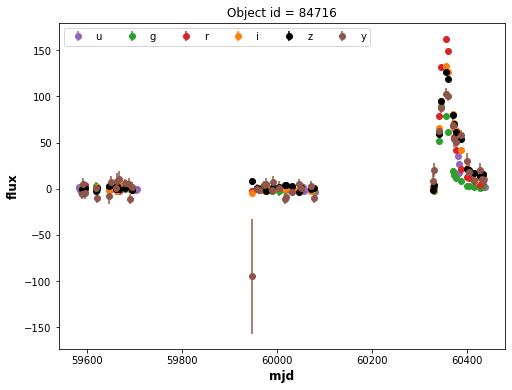

In [18]:
id = 84716
LightCurve(dataframe=lcvs).plot(object_id=id)
plt.title('Object id = {}'.format(id));

**Figure 1:** Above figure shows the example of light curve from an object with an id of 84716. It is defined as a variation of flux as a function of time (in MJD). From the figure, it is clear that for most of the time, source is quite or at the base level, and then suddenly around 60300 mjd,  the flux rises like in a flare and then it comes back to its base value again. This type of flaring activitiy generally can be seen in Active Galactic Neuclei 

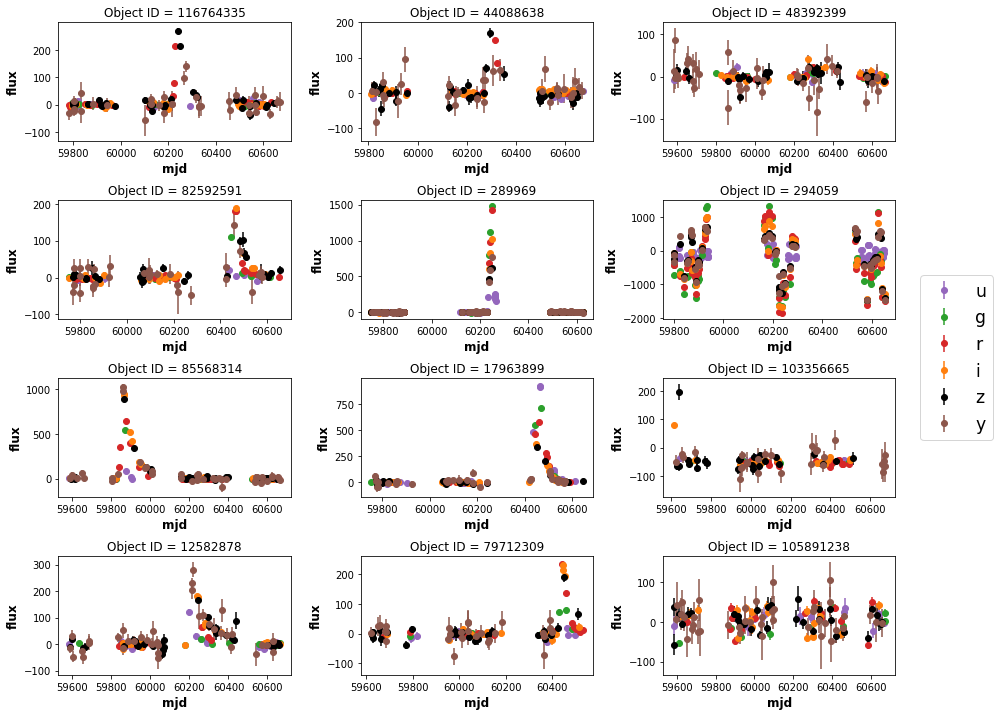

In [19]:
# select 12 object randomly from list of objects
np.random.seed(12)
objects = np.random.choice(lcvs.object_id.unique(), size=12, replace=False)
fig,axes = plt.subplots(4,3, figsize=(15,12))
axes = axes.flatten()
for i in range(len(axes)):
  LightCurve(dataframe=lcvs).plot(object_id=objects[i], ax = axes[i])
  axes[i].set_title('Object ID = {}'.format(objects[i]))
  axes[i].get_legend().remove()  # this is to remove indiviual legend
  
lines, labels = fig.axes[-1].get_legend_handles_labels()  # this is to do one legend for all the figures
fig.legend(lines, labels, loc='center right', fontsize='xx-large')
plt.subplots_adjust(hspace=0.5) ;
plt.subplots_adjust(wspace=0.3)



**Figure 2:** Here is the plot of 12 objects selected randomly from a list of 7848 objects. Mostly the light curves resemble like flaring events. However, some objects are different as well. For example, last object (ID=105891238), looks non transient. Similary object with an ID of 289969, looks like a supernova type of event, that occurs and then gone. Lastly, object 294059 looks like a periodic variation like we can see in binary systems. Rest of the objects looks flaring objects

## Visualize the distribution of each of the feature of the metadata

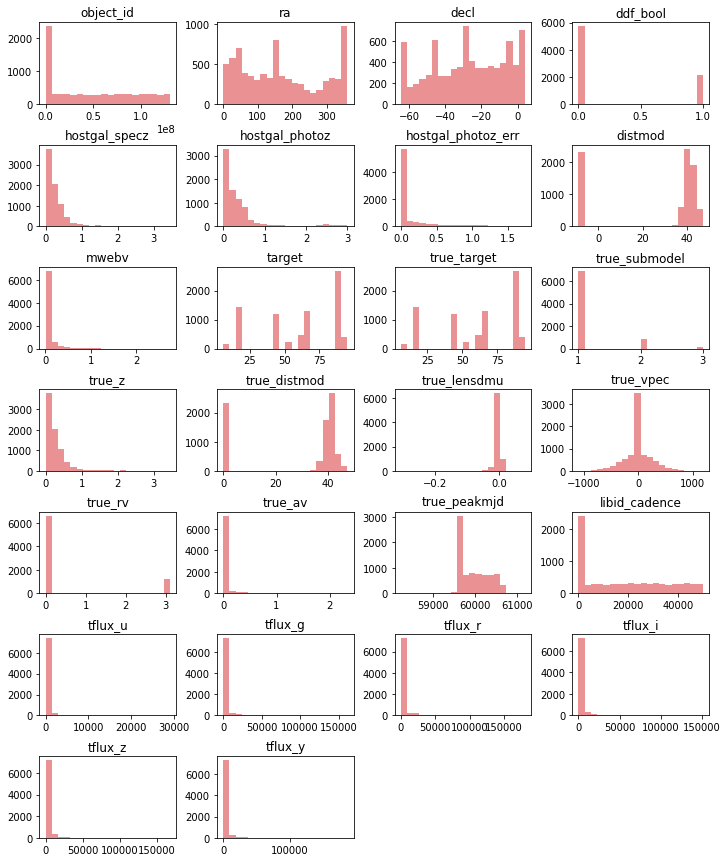

In [80]:
metadata.hist(figsize=(12,15), grid=False, layout=(7,4), color='C3', alpha=0.5, bins=20)
plt.subplots_adjust(hspace=0.5) ;

**Figure 3:** Distribution of all the features in metadata. Distributions looks like powerlaw distriibutions for lot of features specailly the ones having name `flux` in it Ra and Dec distribution looks more or less like uniform.

# TASK III: Extract features - 5 points

### Feature extraction refers to the extraction of statistical features of the datapoints or the generation of low dimensional representations of the data points that can then be passed to a classifier/regression

### * **Minimum Deliverable** Extract at least 4 featues if you are taking PHYS461 and at least 6 if you are taking PHYS661 features including at least 1 feature from all three category below

The code that won the callenge did a number of smart things, of course (it was a feature based classification scheme, which included Gaussian Processes in the preprocessing for interpolation). The feature extraction part of the code is here. https://github.com/kboone/avocado/blob/master/avocado/plasticc.py


Examples of features you can extract:

- **from the original lightcurve**: 
    - mean, 
    - standard deviation, 
    - skewness, 
    - kurthosis, 
    - minimum 
    - maximmum,
    - error on the minimum and 
    - error on the maximum, 
- **from the standardized lightcurve**:
    - median 
    - slope of a line fit
    - intercept of a line fit
    - likelihood of the line fit
    - likelihood of a quadratic fit
    - sign of the quadratic parameter

- **from the metadata file**:
    - decl; this is one of the positions in the sky variables: important because the position on the sky may determin if it is a galactic or extragalactic object
    - ddf_bool ; the kind of survey i.e. the data collection scheme that lead to the time series
    - hostgal_photoz
    - hostgal_photoz_err
    

### TASK III.2 extract some features from the raw lightcurve (`lcvs`). List of features i am planning to extract from raw light curve are
- mean value of light curve of each object at each filter
- Standard deviation
- minimum value
- Maximum value
- Central moments m2, m3 and m4

All of above are continous variables

Mean can have a good sepearating power in model. For example, the mean value of flux for non-transient sources will be same as compared of transient events where mean can be different becasue of one flare (think of it as outlier which will skew the mean towards it). 

Similary minimum and maximum value for non-transient sources will be same even for binary systems. However, flaring objects can flare at different strenght which change the maximum value of flux. 

In [163]:
means = lcvs.groupby(["object_id", "passband"])[["flux"]].mean().rename({"flux":"mean"}, axis=1)
stds = lcvs.groupby(["object_id", "passband"])[["flux"]].std(ddof=1).rename({"flux":"std"}, axis=1)
minimum = lcvs.groupby(["object_id", "passband"])[["flux"]].min().rename({"flux":"min"}, axis=1)
maximum = lcvs.groupby(["object_id", "passband"])[["flux"]].max().rename({"flux":"max"}, axis=1)
m2 = pd.DataFrame(lcvs.groupby(["object_id", "passband"])["flux"].apply(lambda x: stats.moment(x, moment=2))).rename({"flux":"m2"}, axis=1)
m3 = pd.DataFrame(lcvs.groupby(["object_id", "passband"])["flux"].apply(lambda x: stats.moment(x, moment=3))).rename({"flux":"m3"}, axis=1)
m4 = pd.DataFrame(lcvs.groupby(["object_id", "passband"])["flux"].apply(lambda x: stats.moment(x, moment=4))).rename({"flux":"m4"}, axis=1)


### Task III.3 Normalize flux and create new dataframe (`lcvs_norm`)
- Median  ( continous variable)
- slope of line fit ( continuous variable)
- intercept of line fit (continuous)
- log-likehood of line fit (Again continous)
- log-likehood of quadfit (same)

Slope of line fit will change depending upon if we are fitting a line to nontransient source vs transient source. Also the value of goodness of fit (proxy is log-likehood) can also be used as a powerful feature to separate different set of classes.

In [17]:
lcvs_norm = lcvs.copy() 
lcvs_norm["flux_normed"] = lcvs_norm.groupby(['object_id', 'passband'])["flux"].apply(lambda x: (x - x.mean()) / x.std())
medians = pd.DataFrame(lcvs_norm.groupby(['object_id', 'passband'])["flux_normed"].apply(lambda x: x.median())).rename({"flux_normed": "median"}, axis=1)

In [18]:
lcvs_norm.head()

,object_id,mjd,passband,flux,flux_err,detected,flux_normed
0,615,59750.4229,2,-544.810303,3.622952,1,-0.902317
1,615,59750.4306,1,-816.434326,5.553370,1,-0.715759
2,615,59750.4383,3,-471.385529,3.801213,1,-1.044293
3,615,59750.4450,4,-388.984985,11.395031,1,-1.141283
4,615,59752.4070,2,-681.858887,4.041204,1,-1.203442


In [164]:
def linfit(df):
    '''
    fits a line to a lightcurve and returns the parameters:
    input:
      lc: the array containing the lightcurve datapoints
    output:
      slope
      intercept
      '''
    
    polynomial_features= PolynomialFeatures(degree=1)
    X = df['mjd'].to_numpy()
    X = X - X[0]
    xp = polynomial_features.fit_transform(X.reshape(-1,1))
    Y = df["flux_normed"].to_numpy().reshape(-1,1)

   # X = sm.add_constant(X) #adding a constant
    model = sm.OLS(Y, xp).fit()
    pars = model.params
    return np.append(pars, model.llf)

def quadfit(df):
    """
    Fit a polynomial of degree 2
    b0 + b1*X + b2*X**2
    """
    polynomial_features= PolynomialFeatures(degree=2)
    X = df['mjd'].to_numpy()
    X = X - X[0]
    xp = polynomial_features.fit_transform(X.reshape(-1,1))
    Y = df["flux_normed"].to_numpy().reshape(-1,1)
    model = sm.OLS(Y, xp).fit()
    return model.llf



In [165]:
linfits = pd.DataFrame(lcvs_norm.groupby(["object_id", "passband"]).apply(linfit))
linfits["intercept"] = [linfits[0].to_numpy()[i][0] for i in range(len(linfits[0]))]
linfits["slope"] = [linfits[0].to_numpy()[i][1] for i in range(len(linfits[0]))]
linfits["ll1"] = [linfits[0].to_numpy()[i][2] for i in range(len(linfits[0]))]
linfits = linfits.drop([0], axis=1)
#linfits[['intercept','slope', 'll1']] = pd.DataFrame(linfits['0'].tolist(), index= linfits.index)

In [166]:
quadfits = pd.DataFrame(lcvs_norm.groupby(["object_id", "passband"]).apply(quadfit)).rename({0: "ll2"}, axis=1)

### Combine all the dataframe calculated above

In [168]:
data_frames = [means, stds, minimum, maximum, m2, m3, m4, medians, linfits, quadfits]

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['object_id', 'passband'],
                                            how='inner'), data_frames)

In [190]:
df_merged.head()

mean         std  ...        ll1        ll2
object_id passband                          ...                      
615       0          -3.254554   83.944735  ... -88.218652 -84.013092
          1        -385.699911  601.787302  ... -80.869998 -80.867915
          2        -134.146566  455.121346  ... -80.109763 -80.092803
          3        -121.103501  335.425053  ... -79.290039 -79.226482
          4         -55.954592  291.803449  ... -78.480261 -78.160027

[5 rows x 12 columns]

In [170]:
metadata.head()

,object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target,true_target,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,615,349.0461,-61.9438,1,0.000,0.000,0.000,-9.000,0.017,92,92,1,0.000,0.000,0.000,0.0,0.0,0.0,59570.000,69,484.7,3286.7,3214.1,3039.7,2854.5,2837.0
1,713,53.0859,-27.7844,1,1.818,1.627,0.255,45.406,0.007,88,88,1,1.817,45.703,0.000,0.0,0.0,0.0,59570.000,34,108.7,117.7,119.9,149.6,147.9,150.5
2,730,33.5742,-6.5796,1,0.232,0.226,0.016,40.256,0.021,42,42,2,0.233,40.328,0.004,4.5,0.0,0.0,60444.379,9,0.0,0.0,0.0,0.0,0.0,0.0
3,745,0.1899,-45.5867,1,0.304,0.281,1.152,40.795,0.007,90,90,1,0.301,40.969,-0.004,257.7,0.0,0.0,60130.453,38,0.0,0.0,0.0,0.0,0.0,0.0
4,1124,352.7113,-63.8237,1,0.193,0.241,0.018,40.417,0.024,90,90,1,0.193,39.866,-0.002,-368.8,0.0,0.0,60452.641,1,0.0,0.0,0.0,0.0,0.0,0.0


In [171]:
# unstack will do the trick ... !!!make sure you save a copy of your features before maniulating them!!! in vase something goes wrong.
features = df_merged.reset_index().set_index(['object_id','passband']).stack().unstack([1,2])


In [191]:
features.head()

passband          0                         ...         5                      
               mean        std         min  ...     slope        ll1        ll2
object_id                                   ...                                
615       -3.254554  83.944735 -116.913223  ...  0.001003 -77.386461 -76.917754
713       -2.720398   7.113509  -14.735178  ... -0.001978 -65.424297 -65.167686
730       -0.048080   1.828872   -3.459960  ...  0.001259 -67.853917 -66.518080
745        1.797523   4.374445   -3.874349  ...  0.000003 -77.536999 -64.783463
1124       0.660948   2.360084   -6.804703  ...  0.001110 -76.666778 -76.526495

[5 rows x 72 columns]

### Merge feature dataframe with metadata frame on `object_id`

In [245]:
cols = ['object_id', 'decl', 'ddf_bool', 'hostgal_photoz', 'hostgal_photoz_err', 'target']
final_features = pd.merge(features,metadata[cols],on=['object_id'], how='inner')

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [246]:
final_features.head()

,object_id,"(0, mean)","(0, std)","(0, min)","(0, max)","(0, m2)","(0, m3)","(0, m4)","(0, median)","(0, intercept)","(0, slope)","(0, ll1)","(0, ll2)","(1, mean)","(1, std)","(1, min)","(1, max)","(1, m2)","(1, m3)","(1, m4)","(1, median)","(1, intercept)","(1, slope)","(1, ll1)","(1, ll2)","(2, mean)","(2, std)","(2, min)","(2, max)","(2, m2)","(2, m3)","(2, m4)","(2, median)","(2, intercept)","(2, slope)","(2, ll1)","(2, ll2)","(3, mean)","(3, std)","(3, min)","(3, max)","(3, m2)","(3, m3)","(3, m4)","(3, median)","(3, intercept)","(3, slope)","(3, ll1)","(3, ll2)","(4, mean)","(4, std)","(4, min)","(4, max)","(4, m2)","(4, m3)","(4, m4)","(4, median)","(4, intercept)","(4, slope)","(4, ll1)","(4, ll2)","(5, mean)","(5, std)","(5, min)","(5, max)","(5, m2)","(5, m3)","(5, m4)","(5, median)","(5, intercept)","(5, slope)","(5, ll1)","(5, ll2)",decl,ddf_bool,hostgal_photoz,hostgal_photoz_err,target
0,615,-3.254554,83.944735,-116.913223,125.182808,6934.865833,72665.792850,7.433032e+07,-0.080537,-0.240792,0.000524,-88.218652,-84.013092,-385.699911,601.787302,-1100.440063,660.626343,355904.026224,8.593916e+07,2.215166e+11,-0.170090,-0.237681,0.000559,-80.869998,-80.867915,-134.146566,455.121346,-681.858887,611.984558,203564.138816,3.040627e+07,6.659406e+10,-0.289021,-0.318807,0.000750,-80.109763,-80.092803,-121.103501,335.425053,-530.644592,445.737061,110570.138947,1.049664e+07,1.919999e+10,-0.122434,-0.386015,0.000908,-79.290039,-79.226482,-55.954592,291.803449,-422.184509,381.953735,83681.162283,4.717542e+06,1.036570e+10,-0.163078,-0.441033,0.001037,-78.480261,-78.160027,-47.449847,294.779522,-422.815094,378.188141,85370.493377,3.041829e+06,1.049535e+10,-0.129163,-0.432144,0.001003,-77.386461,-76.917754,-61.9438,1,0.000,0.000,92
1,713,-2.720398,7.113509,-14.735178,14.509829,49.879128,89.634243,4.907398e+03,-0.052914,1.328605,-0.002859,-49.801325,-45.801483,-1.019804,5.712334,-11.715749,9.129021,32.048070,-1.551087e+01,1.944373e+03,0.080189,1.166349,-0.002799,-38.161170,-36.052358,-0.794238,5.770738,-10.067919,10.529041,32.706748,-4.127475e+00,1.935955e+03,0.117188,1.181665,-0.002836,-35.611095,-34.410798,-0.986966,6.450413,-12.394593,11.330316,40.864832,-4.249286e+01,3.091660e+03,0.141552,1.145128,-0.002748,-41.302700,-38.701863,-0.900262,6.406989,-12.286801,9.827934,40.316483,-1.597455e+01,2.938985e+03,0.016870,1.117370,-0.002681,-44.870314,-44.424807,-1.794175,7.094073,-14.211164,14.770886,49.427194,7.377121e+01,5.294322e+03,-0.094281,0.824426,-0.001978,-65.424297,-65.167686,-27.7844,1,1.627,0.255,88
2,730,-0.048080,1.828872,-3.459960,5.942166,3.298318,2.093148,3.655013e+01,0.039463,0.051958,-0.000121,-101.606902,-101.249926,0.141057,1.807229,-3.393080,5.693109,3.203266,2.623669e+00,3.870188e+01,0.016754,-0.140403,0.000337,-73.012277,-72.910038,2.400870,5.559483,-2.848838,20.994711,30.313471,3.864890e+02,6.926529e+03,-0.343392,-0.717286,0.001724,-65.193298,-63.777334,3.236164,8.191987,-5.435799,33.572102,65.818099,1.380135e+03,4.048490e+04,-0.314425,-0.656739,0.001578,-66.683538,-66.369632,4.308728,10.710344,-5.836310,41.159981,112.462234,2.936931e+03,1.060595e+05,-0.308522,-0.615831,0.001477,-66.161110,-65.239486,4.539396,13.332758,-19.159811,47.310059,174.276892,3.751336e+03,1.860606e+05,-0.149763,-0.524711,0.001259,-67.853917,-66.518080,-6.5796,1,0.226,0.016,42
3,745,1.797523,4.374445,-3.874349,18.014029,18.869993,162.368381,2.575248e+03,-0.169349,0.300509,-0.000700,-100.184915,-88.423048,5.717394,25.964659,-3.618410,192.244293,662.124902,1.161627e+05,2.162844e+07,-0.185994,0.038537,-0.000092,-78.932796,-76.313623,9.711532,31.957997,-2.159753,220.795212,1003.075853,1.758302e+05,3.606109e+07,-0.290606,0.033903,-0.000081,-78.938052,-72.846380,14.412924,34.967698,-4.944036,203.250702,1200.905234,1.519142e+05,2.575691e+07,-0.373246,0.026106,-0.000062,-78.945375,-67.105516,13.134436,33.069053,-15.494463,183.633118,1074.034376,1.190633e+05,1.781661e+07,-0.358773,0.045135,-0.000108,-78.924149,-67.067827,10.746138,26.060130,-10.24

#### Rename column names for easy read

In [247]:
col_oldname = final_features.columns.to_numpy()
col_rename = ['_'.join((str(i[0]), str(i[1]))) if type(i) == tuple else i for i in col_oldname]

In [248]:
map_names = {}
for A, B in zip(col_oldname, col_rename):
    map_names[A] = B

In [249]:
#final_features.rename(columns=map_names).to_csv('/content/drive/MyDrive/DSPSFinalExam/final_features.csv')

In [250]:
final_features = final_features.rename(columns=map_names)

In [251]:
final_features.head()

,object_id,0_mean,0_std,0_min,0_max,0_m2,0_m3,0_m4,0_median,0_intercept,0_slope,0_ll1,0_ll2,1_mean,1_std,1_min,1_max,1_m2,1_m3,1_m4,1_median,1_intercept,1_slope,1_ll1,1_ll2,2_mean,2_std,2_min,2_max,2_m2,2_m3,2_m4,2_median,2_intercept,2_slope,2_ll1,2_ll2,3_mean,3_std,3_min,3_max,3_m2,3_m3,3_m4,3_median,3_intercept,3_slope,3_ll1,3_ll2,4_mean,4_std,4_min,4_max,4_m2,4_m3,4_m4,4_median,4_intercept,4_slope,4_ll1,4_ll2,5_mean,5_std,5_min,5_max,5_m2,5_m3,5_m4,5_median,5_intercept,5_slope,5_ll1,5_ll2,decl,ddf_bool,hostgal_photoz,hostgal_photoz_err,target
0,615,-3.254554,83.944735,-116.913223,125.182808,6934.865833,72665.792850,7.433032e+07,-0.080537,-0.240792,0.000524,-88.218652,-84.013092,-385.699911,601.787302,-1100.440063,660.626343,355904.026224,8.593916e+07,2.215166e+11,-0.170090,-0.237681,0.000559,-80.869998,-80.867915,-134.146566,455.121346,-681.858887,611.984558,203564.138816,3.040627e+07,6.659406e+10,-0.289021,-0.318807,0.000750,-80.109763,-80.092803,-121.103501,335.425053,-530.644592,445.737061,110570.138947,1.049664e+07,1.919999e+10,-0.122434,-0.386015,0.000908,-79.290039,-79.226482,-55.954592,291.803449,-422.184509,381.953735,83681.162283,4.717542e+06,1.036570e+10,-0.163078,-0.441033,0.001037,-78.480261,-78.160027,-47.449847,294.779522,-422.815094,378.188141,85370.493377,3.041829e+06,1.049535e+10,-0.129163,-0.432144,0.001003,-77.386461,-76.917754,-61.9438,1,0.000,0.000,92
1,713,-2.720398,7.113509,-14.735178,14.509829,49.879128,89.634243,4.907398e+03,-0.052914,1.328605,-0.002859,-49.801325,-45.801483,-1.019804,5.712334,-11.715749,9.129021,32.048070,-1.551087e+01,1.944373e+03,0.080189,1.166349,-0.002799,-38.161170,-36.052358,-0.794238,5.770738,-10.067919,10.529041,32.706748,-4.127475e+00,1.935955e+03,0.117188,1.181665,-0.002836,-35.611095,-34.410798,-0.986966,6.450413,-12.394593,11.330316,40.864832,-4.249286e+01,3.091660e+03,0.141552,1.145128,-0.002748,-41.302700,-38.701863,-0.900262,6.406989,-12.286801,9.827934,40.316483,-1.597455e+01,2.938985e+03,0.016870,1.117370,-0.002681,-44.870314,-44.424807,-1.794175,7.094073,-14.211164,14.770886,49.427194,7.377121e+01,5.294322e+03,-0.094281,0.824426,-0.001978,-65.424297,-65.167686,-27.7844,1,1.627,0.255,88
2,730,-0.048080,1.828872,-3.459960,5.942166,3.298318,2.093148,3.655013e+01,0.039463,0.051958,-0.000121,-101.606902,-101.249926,0.141057,1.807229,-3.393080,5.693109,3.203266,2.623669e+00,3.870188e+01,0.016754,-0.140403,0.000337,-73.012277,-72.910038,2.400870,5.559483,-2.848838,20.994711,30.313471,3.864890e+02,6.926529e+03,-0.343392,-0.717286,0.001724,-65.193298,-63.777334,3.236164,8.191987,-5.435799,33.572102,65.818099,1.380135e+03,4.048490e+04,-0.314425,-0.656739,0.001578,-66.683538,-66.369632,4.308728,10.710344,-5.836310,41.159981,112.462234,2.936931e+03,1.060595e+05,-0.308522,-0.615831,0.001477,-66.161110,-65.239486,4.539396,13.332758,-19.159811,47.310059,174.276892,3.751336e+03,1.860606e+05,-0.149763,-0.524711,0.001259,-67.853917,-66.518080,-6.5796,1,0.226,0.016,42
3,745,1.797523,4.374445,-3.874349,18.014029,18.869993,162.368381,2.575248e+03,-0.169349,0.300509,-0.000700,-100.184915,-88.423048,5.717394,25.964659,-3.618410,192.244293,662.124902,1.161627e+05,2.162844e+07,-0.185994,0.038537,-0.000092,-78.932796,-76.313623,9.711532,31.957997,-2.159753,220.795212,1003.075853,1.758302e+05,3.606109e+07,-0.290606,0.033903,-0.000081,-78.938052,-72.846380,14.412924,34.967698,-4.944036,203.250702,1200.905234,1.519142e+05,2.575691e+07,-0.373246,0.026106,-0.000062,-78.945375,-67.105516,13.134436,33.069053,-15.494463,183.633118,1074.034376,1.190633e+05,1.781661e+07,-0.358773,0.045135,-0.000108,-78.924149,-67.067827,10.746138,26.060130,-10.249387,141.513290,666.782529,5.309464e+04,6.203072e+06,-0.306851,-0.001092,0.000003,-77.536999,-64.783463,-45.5867,1,0.281,1.152,90
4,1124,0.660948,2.360084,-6.804703,5.330927,5.481586,-4.160853,1.101222e+02,-0.033864,-0.567576,0.001234,-84.969286,-84.959510,4.634637,8.107525,-2.622109,37.170177,64.598653,1.202103e+03,3.545471e+04,-0.429236,-0.793184,0.001865,

In [255]:
print("My feature space has {} features".format(final_features.shape[1]))

My feature space has 78 features


#  PART II: Classifying:
- Note I am planning to use random forest method for classification, in which scaling is not necessary. Therefore I am not applying in scaling. I will do it latter when I will plot high dimensional data in 2 dimensional space

<font color='red'>Here I am loading final features csv file from my google drive. It is a saved version!</font>

In [20]:
final_features = pd.read_csv('final_features.csv', index_col=[0])

In [21]:
final_features.head()

,object_id,0_mean,0_std,0_min,0_max,0_m2,0_m3,0_m4,0_median,0_intercept,0_slope,0_ll1,0_ll2,1_mean,1_std,1_min,1_max,1_m2,1_m3,1_m4,1_median,1_intercept,1_slope,1_ll1,1_ll2,2_mean,2_std,2_min,2_max,2_m2,2_m3,2_m4,2_median,2_intercept,2_slope,2_ll1,2_ll2,3_mean,3_std,3_min,3_max,3_m2,3_m3,3_m4,3_median,3_intercept,3_slope,3_ll1,3_ll2,4_mean,4_std,4_min,4_max,4_m2,4_m3,4_m4,4_median,4_intercept,4_slope,4_ll1,4_ll2,5_mean,5_std,5_min,5_max,5_m2,5_m3,5_m4,5_median,5_intercept,5_slope,5_ll1,5_ll2,decl,ddf_bool,hostgal_photoz,hostgal_photoz_err,target
0,615,-3.254554,83.944735,-116.913223,125.182808,6934.865833,72665.792850,7.433032e+07,-0.080537,-0.240792,0.000524,-88.218652,-84.013092,-385.699911,601.787302,-1100.440063,660.626343,355904.026224,8.593916e+07,2.215166e+11,-0.170090,-0.237681,0.000559,-80.869998,-80.867915,-134.146566,455.121346,-681.858887,611.984558,203564.138816,3.040627e+07,6.659406e+10,-0.289021,-0.318807,0.000750,-80.109763,-80.092803,-121.103501,335.425053,-530.644592,445.737061,110570.138947,1.049664e+07,1.919999e+10,-0.122434,-0.386015,0.000908,-79.290039,-79.226482,-55.954592,291.803449,-422.184509,381.953735,83681.162283,4.717542e+06,1.036570e+10,-0.163078,-0.441033,0.001037,-78.480261,-78.160027,-47.449847,294.779522,-422.815094,378.188141,85370.493377,3.041829e+06,1.049535e+10,-0.129163,-0.432144,0.001003,-77.386461,-76.917754,-61.9438,1,0.000,0.000,92
1,713,-2.720398,7.113509,-14.735178,14.509829,49.879128,89.634243,4.907398e+03,-0.052914,1.328605,-0.002859,-49.801325,-45.801483,-1.019804,5.712334,-11.715749,9.129021,32.048070,-1.551087e+01,1.944373e+03,0.080189,1.166349,-0.002799,-38.161170,-36.052358,-0.794238,5.770738,-10.067919,10.529041,32.706748,-4.127475e+00,1.935955e+03,0.117188,1.181665,-0.002836,-35.611095,-34.410798,-0.986966,6.450413,-12.394593,11.330316,40.864832,-4.249286e+01,3.091660e+03,0.141552,1.145128,-0.002748,-41.302700,-38.701863,-0.900262,6.406989,-12.286801,9.827934,40.316483,-1.597455e+01,2.938985e+03,0.016870,1.117370,-0.002681,-44.870314,-44.424807,-1.794175,7.094073,-14.211164,14.770886,49.427194,7.377121e+01,5.294322e+03,-0.094281,0.824426,-0.001978,-65.424297,-65.167686,-27.7844,1,1.627,0.255,88
2,730,-0.048080,1.828872,-3.459960,5.942166,3.298318,2.093148,3.655013e+01,0.039463,0.051958,-0.000121,-101.606902,-101.249926,0.141057,1.807229,-3.393080,5.693109,3.203266,2.623669e+00,3.870188e+01,0.016754,-0.140403,0.000337,-73.012277,-72.910038,2.400870,5.559483,-2.848838,20.994711,30.313471,3.864890e+02,6.926529e+03,-0.343392,-0.717286,0.001724,-65.193298,-63.777334,3.236164,8.191987,-5.435799,33.572102,65.818099,1.380135e+03,4.048490e+04,-0.314425,-0.656739,0.001578,-66.683538,-66.369632,4.308728,10.710344,-5.836310,41.159981,112.462234,2.936931e+03,1.060595e+05,-0.308522,-0.615831,0.001477,-66.161110,-65.239486,4.539396,13.332758,-19.159811,47.310059,174.276892,3.751336e+03,1.860606e+05,-0.149763,-0.524711,0.001259,-67.853917,-66.518080,-6.5796,1,0.226,0.016,42
3,745,1.797523,4.374445,-3.874349,18.014029,18.869993,162.368381,2.575248e+03,-0.169349,0.300509,-0.000700,-100.184915,-88.423048,5.717394,25.964659,-3.618410,192.244293,662.124902,1.161627e+05,2.162844e+07,-0.185994,0.038537,-0.000092,-78.932796,-76.313623,9.711532,31.957997,-2.159753,220.795212,1003.075853,1.758302e+05,3.606109e+07,-0.290606,0.033903,-0.000081,-78.938052,-72.846380,14.412924,34.967698,-4.944036,203.250702,1200.905234,1.519142e+05,2.575691e+07,-0.373246,0.026106,-0.000062,-78.945375,-67.105516,13.134436,33.069053,-15.494463,183.633118,1074.034376,1.190633e+05,1.781661e+07,-0.358773,0.045135,-0.000108,-78.924149,-67.067827,10.746138,26.060130,-10.249387,141.513290,666.782529,5.309464e+04,6.203072e+06,-0.306851,-0.001092,0.000003,-77.536999,-64.783463,-45.5867,1,0.281,1.152,90
4,1124,0.660948,2.360084,-6.804703,5.330927,5.481586,-4.160853,1.101222e+02,-0.033864,-0.567576,0.001234,-84.969286,-84.959510,4.634637,8.107525,-2.622109,37.170177,64.598653,1.202103e+03,3.545471e+04,-0.429236,-0.793184,0.001865,

In [22]:
final_features.isnull().values.any()

False

There are no nan values in the final features dataframe

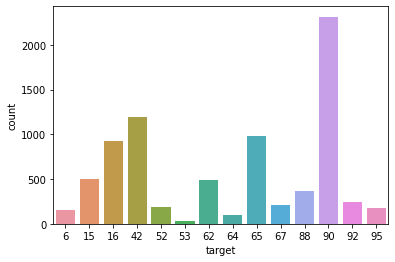

In [23]:
sns.countplot(x="target", data=final_features);

**Figure 4:** List of classes which we are planning to seperate based on lot of features in our datasets. You can see class type `90` has maximum number of entires in our datasets while class type `53` has minimum number of entires.

## TASK V Easy classification task: 

### TASK V.I Build a model and fit it to the data

use as target variable **ddf_bool** - this is the kind of survey, i.e. the kind of observing strategy that is implemented. DDF stands for Deep Drilling Field and the observations are much more dense in time. This classification should be achievable.


### I will be using decision tree algorithm (Random Forest) in the first go 

In [24]:
col_used = final_features.columns[1:-1].to_numpy()
col_names = np.delete(col_used, np.where(col_used == 'ddf_bool')) 
y = np.delete(col_used, np.where(col_used != 'ddf_bool')) 

In [25]:
X = final_features[col_names]
y = final_features[y]
le = LabelEncoder()
y = le.fit_transform(y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Splitting into train and test sets

In [26]:
X_train, X_test, y_train, y_test =train_test_split(X, y,test_size=0.35, random_state=10)

In [27]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [28]:
print("Accuracy score Random Forest train data = {:.3f}".format(accuracy_score(y_train, rf.predict(X_train))))

Accuracy score Random Forest train data = 1.000


In [29]:
print("Accuracy score Random Forest test data = {:.3f}".format(accuracy_score(y_test, rf.predict(X_test))))


Accuracy score Random Forest test data = 0.999


In [30]:
data={'feature_names':col_names,'feature_importance':rf.feature_importances_}
fi_df = pd.DataFrame(data)
fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
fi_df["cumulative"] = fi_df.feature_importance.to_numpy().cumsum()


In [31]:
fi_df.head(15)

,feature_names,feature_importance,cumulative
34,2_ll1,0.161405,0.161405
10,0_ll1,0.145385,0.306790
46,3_ll1,0.130392,0.437182
22,1_ll1,0.117761,0.554943
11,0_ll2,0.094057,0.649001
23,1_ll2,0.056974,0.705975
47,3_ll2,0.049219,0.755193
35,2_ll2,0.035259,0.790452
50,4_min,0.031593,0.822045
62,5_min,0.025309,0.847354


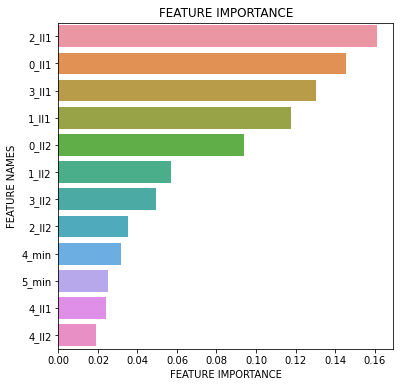

In [32]:
plt.figure(figsize=(6,6))
#Plot Searborn bar chart
sns.barplot(x=fi_df[fi_df.cumulative <= 0.90]['feature_importance'], y=fi_df[fi_df.cumulative <= 0.90]['feature_names'])
#Add chart labels
plt.title('FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES') ;

**Figure 5:** Shows the importance of features in desecnding order, means `2_ll1` is the most important feature to sepeerate ddf_bool 1 from ddf_bool 0.

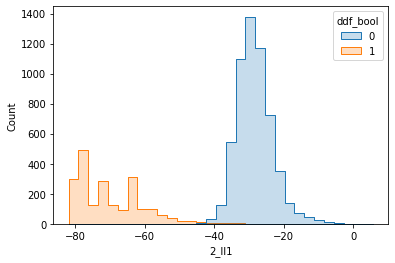

In [127]:
sns.histplot(data=final_features, x="2_ll1", hue="ddf_bool", element="step");

**Figure 6:** It is clear from the above figure also, the distribution of feature value is well seperated between signal and background. thats is why our model is giving us 100 percent accuracy. Not surprising. Bascially ddf 1 are deeper exposure observations as comapre to ddf 0. More data leads to more discrepancy between data and model (since linear fit is not a good fit here, specially with transients). Therefore likelihhod is worse for ddf=1

## Lets reduce the number of features used in the model
- Use only features upto cumulative importance of 60%
- It means these features define 60% variation in our data
- Even with this many feature (only 4), we can acheive model accuracy of 100 percent on test dataset

In [34]:
col_names = fi_df[fi_df.cumulative <= 0.60]['feature_names'].to_numpy()
y = np.delete(col_used, np.where(col_used != 'ddf_bool')) 

X = final_features[col_names]
y = final_features[y]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =train_test_split(X, y,test_size=0.35, random_state=14)
rf = RandomForestClassifier(random_state = 0, max_depth=3)
rf.fit(X_train,y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomForestClassifier(max_depth=3, random_state=0)

In [36]:
len(col_names), col_names

(4, array(['2_ll1', '0_ll1', '3_ll1', '1_ll1'], dtype=object))

In [119]:
print("Accuracy score Random Forest train data = {:.3f}".format(accuracy_score(y_train, rf.predict(X_train))))

Accuracy score Random Forest train data = 1.000


In [120]:
print("Accuracy score Random Forest test data = {:.3f}".format(accuracy_score(y_test, rf.predict(X_test))))


Accuracy score Random Forest test data = 1.000


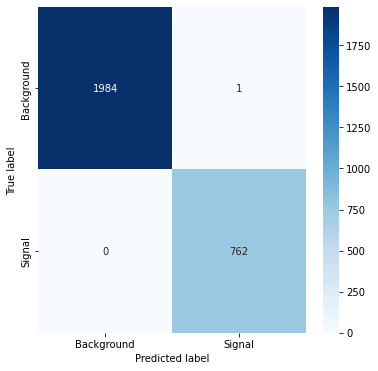

In [121]:
cm_rf = confusion_matrix(y_test, rf.predict(X_test))
fig,axes = plt.subplots(figsize=(6,6))
sns.heatmap(cm_rf,annot=True,cmap='Blues',ax=axes, fmt='.0f',cbar=True)
classNames = ['Background','Signal']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.array([0.5,1.5])
plt.xticks(tick_marks, classNames, rotation=0)
plt.yticks(tick_marks, classNames);



**Figure 7:** Confusion matrix clearly show the prediction of our model where we only use features accoung for 60% of data variavtion (cumultive importance < 0.60). you can see, there is only one evnet in the test data set which is wrongly identified. Pretty good model

## TASK VI Harder classification task - mandatory for 661 EC for 461:


### TASK VI.I Build a model and fit it to the data
Use an apprioriate classification method given your features dataset to classify objects predicting the "target" according to the **target** variable of the in the mtadata dataframe for both DDF and normal survey separately

### Lets divide our `final_features` dataset into two different datasets and train them sepeately. It make sense to do so since we have alreadt seen from our previous Task V, that normal survey and deep survey, features show well sepeatred distributions.

In [37]:
ds_final_features = final_features[final_features.ddf_bool == True]
ns_final_features = final_features[final_features.ddf_bool == False]


In [38]:
ds_final_features.shape

(2116, 78)

In [39]:
ns_final_features.shape

(5732, 78)

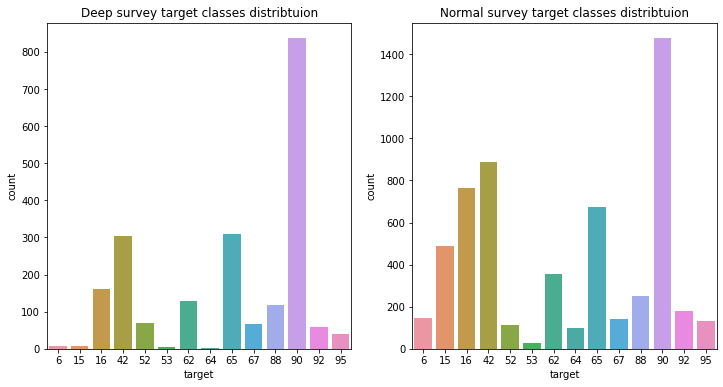

In [42]:
fig,axes = plt.subplots(1,2, figsize=(12,6))
sns.countplot(x="target", data=ds_final_features,ax = axes[0]);
sns.countplot(x="target", data=ns_final_features,ax = axes[1]);
axes[0].set_title('Deep survey target classes distribtuion')
axes[1].set_title('Normal survey target classes distribtuion');


## Normal Survey data training

In [69]:
col_names = ns_final_features.columns[1:].to_numpy()
col_used = np.delete(col_names, np.where((col_names == 'ddf_bool') | (col_names == 'target'))) 
y = np.delete(col_names, np.where(col_names != 'target')) 

In [70]:
col_used, y

(array(['0_mean', '0_std', '0_min', '0_max', '0_m2', '0_m3', '0_m4',
        '0_median', '0_intercept', '0_slope', '0_ll1', '0_ll2', '1_mean',
        '1_std', '1_min', '1_max', '1_m2', '1_m3', '1_m4', '1_median',
        '1_intercept', '1_slope', '1_ll1', '1_ll2', '2_mean', '2_std',
        '2_min', '2_max', '2_m2', '2_m3', '2_m4', '2_median',
        '2_intercept', '2_slope', '2_ll1', '2_ll2', '3_mean', '3_std',
        '3_min', '3_max', '3_m2', '3_m3', '3_m4', '3_median',
        '3_intercept', '3_slope', '3_ll1', '3_ll2', '4_mean', '4_std',
        '4_min', '4_max', '4_m2', '4_m3', '4_m4', '4_median',
        '4_intercept', '4_slope', '4_ll1', '4_ll2', '5_mean', '5_std',
        '5_min', '5_max', '5_m2', '5_m3', '5_m4', '5_median',
        '5_intercept', '5_slope', '5_ll1', '5_ll2', 'decl',
        'hostgal_photoz', 'hostgal_photoz_err'], dtype=object),
 array(['target'], dtype=object))

In [71]:
X = ns_final_features[col_used]
y = ns_final_features[y]
le = LabelEncoder()
y = le.fit_transform(y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [72]:
X_train, X_test, y_train, y_test =train_test_split(X, y,test_size=0.35, random_state=18)
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=0)

In [73]:
print("Accuracy score Random Forest train data = {:.3f}".format(accuracy_score(y_train, rf.predict(X_train))))

Accuracy score Random Forest train data = 1.000


In [74]:
print("Accuracy score Random Forest train data = {:.3f}".format(accuracy_score(y_test, rf.predict(X_test))))


Accuracy score Random Forest train data = 0.708


In [76]:
data={'feature_names':col_used,'feature_importance':rf.feature_importances_}
fi_df = pd.DataFrame(data)
fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
fi_df["cumulative"] = fi_df.feature_importance.to_numpy().cumsum()

In [77]:
fi_df.head()

,feature_names,feature_importance,cumulative
73,hostgal_photoz,0.095747,0.095747
74,hostgal_photoz_err,0.065625,0.161373
29,2_m3,0.036408,0.197781
41,3_m3,0.027602,0.225384
14,1_min,0.025689,0.251073


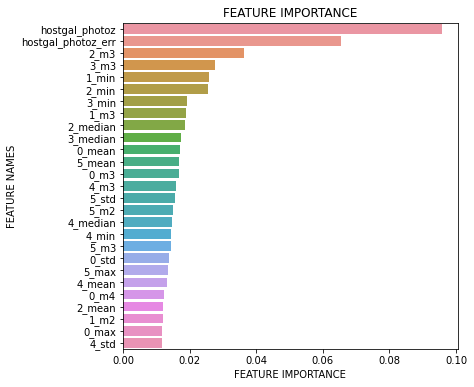

In [80]:
plt.figure(figsize=(6,6))
#Plot Searborn bar chart
sns.barplot(x=fi_df[fi_df.cumulative <= 0.60]['feature_importance'], y=fi_df[fi_df.cumulative <= 0.60]['feature_names'])
#Add chart labels
plt.title('FEATURE IMPORTANCE')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES') ;

In [88]:
class_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(class_name_mapping)

{6: 0, 15: 1, 16: 2, 42: 3, 52: 4, 53: 5, 62: 6, 64: 7, 65: 8, 67: 9, 88: 10, 90: 11, 92: 12, 95: 13}


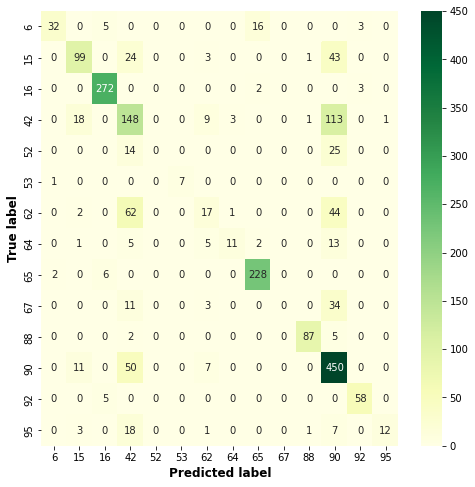

In [99]:
cm_rf = confusion_matrix(y_test, rf.predict(X_test))
fig,axes = plt.subplots(figsize=(8,8))
sns.heatmap(cm_rf,annot=True,cmap='YlGn',ax=axes, fmt='.0f',cbar=True);
axes.set_xticklabels(class_name_mapping)
axes.set_yticklabels(class_name_mapping)
plt.ylabel('True label', fontsize=12, weight='bold')
plt.xlabel('Predicted label', fontsize=12, weight='bold');


**Figure 10:** Confusion Matrix,  interesting most of the labels which are misclassififed are misclassfied as class `90`. This kind ofm ake sense since this class is the most dominant class in our dataset.

### Here I will use in build method in sklearn for best parameter search.

In [102]:
distributions = {'max_depth': [10, 20, None], 'learning_rate': [0.01,0.1,1],
                 'max_features': ['sqrt', 'log2'], 'n_estimators': [50,100], 
                'min_samples_leaf':[int(0.001*len(y_train)), int(0.005*len(y_train)), int(0.05*len(y_train))]}

In [103]:
distributions

{'max_depth': [10, 20, None],
 'max_features': ['sqrt', 'log2'],
 'min_samples_leaf': [3, 18, 186],
 'n_estimators': [50, 100]}

In [104]:
rf = RandomForestClassifier(random_state=0)
clf = RandomizedSearchCV(rf, distributions, random_state=5, n_iter=2, cv=3)


In [105]:
search = clf.fit(X_train, y_train)

In [106]:
search.best_estimator_

RandomForestClassifier(max_features='log2', min_samples_leaf=3, random_state=0)

In [107]:
rf_optimized = RandomForestClassifier(random_state=0, **search.best_params_)
print(rf_optimized)



RandomForestClassifier(max_features='log2', min_samples_leaf=3, random_state=0)


In [108]:
rf_optimized.fit(X_train,y_train)

RandomForestClassifier(max_features='log2', min_samples_leaf=3, random_state=0)

In [109]:
print("Accuracy score Random Forest train data = {:.2f}".format(accuracy_score(y_train, rf_optimized.predict(X_train))))
print("Accuracy score Random Forest test data = {:.2f}".format(accuracy_score(y_test, rf_optimized.predict(X_test))))

Accuracy score Random Forest train data = 0.96
Accuracy score Random Forest test data = 0.70


## Deep Survey data training

In [112]:
col_names = ds_final_features.columns[1:].to_numpy()
col_used = np.delete(col_names, np.where((col_names == 'ddf_bool') | (col_names == 'target'))) 
y = np.delete(col_names, np.where(col_names != 'target')) 

X = ds_final_features[col_used]
y = ds_final_features[y]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =train_test_split(X, y,test_size=0.35, random_state=22)
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train)

print("Accuracy score Random Forest train data = {:.3f}".format(accuracy_score(y_train, rf.predict(X_train))))
print("Accuracy score Random Forest test data = {:.3f}".format(accuracy_score(y_test, rf.predict(X_test))))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy score Random Forest train data = 1.000
Accuracy score Random Forest test data = 0.808


Model trained on deep survey data is more accuarate as compared to normal survey specially for test data

## Standardize the datset and again train the model

In [116]:
col_names = ns_final_features.columns[1:].to_numpy()
col_used = np.delete(col_names, np.where((col_names == 'ddf_bool') | (col_names == 'target'))) 
y = np.delete(col_names, np.where(col_names != 'target')) 

X = ns_final_features[col_used]
y = ns_final_features[y]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =train_test_split(X, y,test_size=0.35, random_state=22)
rf = RandomForestClassifier(random_state = 0)
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(preprocessing.StandardScaler(), rf)
pipe.fit(X_train,y_train)

print("Accuracy score Random Forest train data = {:.3f}".format(accuracy_score(y_train, pipe.predict(X_train))))
print("Accuracy score Random Forest test data = {:.3f}".format(accuracy_score(y_test, pipe.predict(X_test))))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy score Random Forest train data = 1.000
Accuracy score Random Forest test data = 0.693


# EC: try to visualize the features. This is a high dimensional parameter space. you can for example try 2D t-SNE projection of your feature space and visualize it. 
If you are lucky, this will be a pretty plot!
a great model to **Visualize** structure in data is  t-SNE. Any other option you come up with is ok! You can choose to use the code below or to not to, there will be no penalty.

In [120]:
scaler = preprocessing.StandardScaler().fit(X_train)

In [121]:
X_scaled = scaler.transform(X_train)

In [123]:
X_scaled.shape

(3725, 75)

In [125]:
from sklearn.manifold import TSNE

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


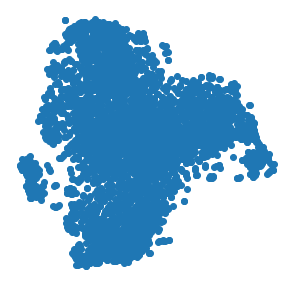

In [127]:
X_embedded = TSNE(n_components=2, random_state=345).fit_transform(X_scaled)
X_embedded.shape
plt.figure(figsize=(5,5))
plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.axis('off')
plt.show()

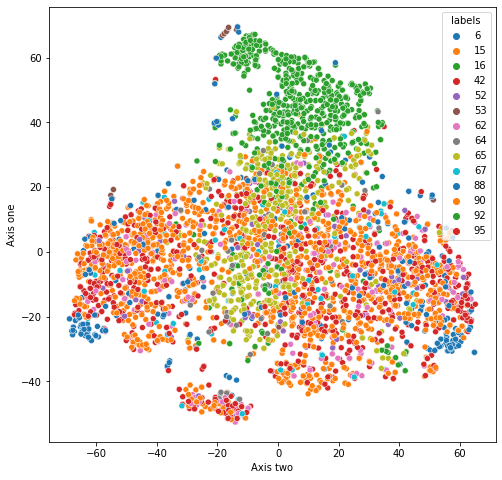

In [166]:
flip_mapping = dict((v,k) for k,v in class_name_mapping.items())
df_tsne = pd.DataFrame()
df_tsne['Axis one'] = X_embedded[:,0]
df_tsne['Axis two'] = X_embedded[:,1]
df_tsne['labels'] = pd.Series(y_train).map(flip_mapping)

plt.figure(figsize=(8,8))
sns.scatterplot(
    x="Axis two", y="Axis one",
    hue='labels',
    data=df_tsne,
    palette=sns.color_palette("tab10",14),
    legend="full",
    alpha=1.0
);